# TPU setting

In [1]:
import tensorflow as tf
import os

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [2]:
strategy = tf.distribute.TPUStrategy(resolver)

# LSTM

`-` 이하 Long Short Term Memory

* 앞서  RNN에서는 기울기 소실 문제가 발생한다고 언급하였다.

* 즉, 문장의 길이가 길어지거나, 긴 기간 동안의 정보를 유지하고 활용하는데 어려움이 발생한다.

* LSTM은 다음과 같은 아이디어를 제시하며 문제를 극복하였음.

`1` cell state

* 현재 셀 상태

* `cell state`는  `Input Gate`와 `Forget Gate`를 통해서 업데이트 됨

* 중요한 점은 과거 정보 중 불필요한 정보는 잊고, 중요한 정보만 뽑아내는 셀 상태를 업데이트 하는 것이다.

* Forget Gate ($C_t$ : t시점의 셀상태)

$$f_t = \sigma(w_{f}\cdot[h_{t-1}, x_t] + b_{f})$$

$$C_{t} = f_t \times C_{t-1}$$

* input gate

$$i_t = \sigma(W_i \cdot[h_{t-1},x_t]+ b)$$

$$\tilde {C}_t = \text{tanh}(W_c \cdot [h_{t-1}, x_t] + b_{c`})$$

* **Update cell state**

$$C_t = (f_t  \times C_{t-1}) + (i_t \times \tilde {C}_t)$$

`2`  Hidden State 업데이트

* 업데이트된  Cell state와 input,  $h_{t-1}$의 정보를 이용하여 $h_t$ 업데이트

* output gate

$$o_{t} =  \sigma(W_{o}[h_{t-1}, x_t] + b_0)$$

* Hidden state 업데이트

$$h_t = o_t \times \text{tanh} (C_t)$$

`3` 이를 도식화하면!

<center><img src="https://wikidocs.net/images/page/152773/2.JPG"  widht=250></center>

## 실습 . IMDB 데이터

In [5]:
import tensorflow as tf

In [9]:
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

### (1) 데이터 로드 및 전처리

In [13]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data()

`-` 주어진 데이터는 정수인코딩이 되어 있으므로 일단 maxlen을 세어보자

In [15]:
max([len(i) for i in x_train]), max([len(i) for i in x_test])

(2494, 2315)

`-` 이전에 RNN 모형에서 `maxlen`을  20으로 설정했는데 위에 수치를 보니 그러면 안될 것 같다. 적당히 500정도로 잡자..

In [18]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen = 500)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen = 500)

`-` shape 확인

In [20]:
x_train.shape, x_test.shape

((25000, 500), (25000, 500))

`-` 고유단어개수 확인

In [23]:
len(set([j for i in x_train for j in i]))

85524

### (2) LSTM 모델링

In [25]:
tf.keras.backend.clear_session()

with strategy.scope() :
        X = Input(shape = [500])

        h1 = Embedding(input_dim = 85524, output_dim = 120)(X)
        h2 = LSTM(120)(h1)

        Y = Dense(1, activation = "sigmoid")(h2)

        model = Model(X, Y)
        model.compile(loss = tf.keras.losses.binary_crossentropy,
                                    optimizer = Adam(0.01))

### (3) 모델 학습

In [27]:
h=model.fit(x_train, y_train, epochs= 10, validation_split = 0.2,
                  verbose = 0).history

### (4) train, val loss 확인

In [28]:
import matplotlib.pyplot as plt

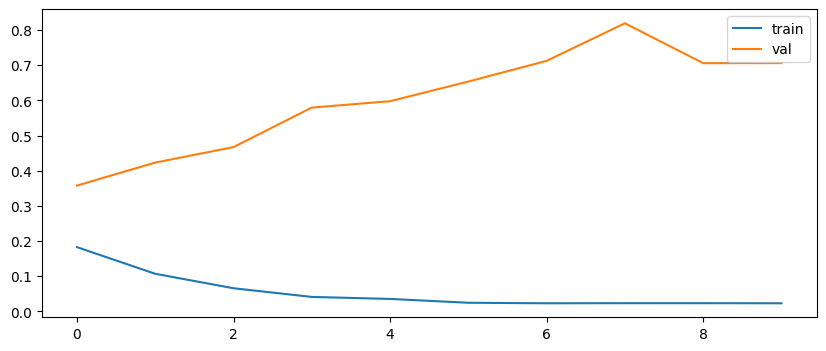

In [29]:
plt.figure(figsize = (10,4))
plt.plot(h["loss"], label = "train")
plt.plot(h["val_loss"], label = "val")
plt.legend()
plt.show()

### (5) 예측

In [30]:
pred = model.predict(x_test)

782/782 [==============================] - 15s 17ms/step


In [32]:
import numpy as np

In [34]:
y_pred = np.where(pred>=0.5, 1, 0)

In [35]:
from sklearn.metrics import *

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82     12500
           1       0.83      0.82      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



`-` 오 아까 RNN보다 성능이 좋게 나왔다

## ref

[ratsgo's NLPBOOK](https://ratsgo.github.io/nlpbook/) : Copyright © 2020 Gichang LEE.